In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from imblearn.over_sampling  import RandomOverSampler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from numpy import mean, std
from sklearn import tree

ModuleNotFoundError: No module named 'seaborn'

In [2]:
vulnerability_data = pd.read_csv("tomcat_vulnerabilities.csv")
np.set_printoptions(threshold=np.inf)
pd.set_option('max_columns',None)

In [3]:
# DATA CLEANING
df = pd.DataFrame(vulnerability_data)
df.loc[df['title'].str.contains('Denial', case=False),'title'] = 'DoS'
df.loc[df['title'].str.contains('CSRF', case=False),'title'] = 'CSRF'
df.loc[df['title'].str.contains('information disclosure', case=False),'title'] = 'Information Disclosure'
df.loc[df['title'].str.contains('cve-2020-9484', case=False),'title'] = 'Remote Code execution'
df.loc[df['title'].str.contains('session hijacking', case=False),'title'] = 'Remote Code execution'
df = df.drop(columns=['Unnamed: 0'])

In [51]:
df = df.drop_duplicates(keep='first').reset_index(drop=True)

In [109]:
df.loc[df.version==9]

,file,class,cbo,wmc,dit,rfc,lcom,tcc,lcc,totalMethodsQty,staticMethodsQty,publicMethodsQty,privateMethodsQty,protectedMethodsQty,defaultMethodsQty,visibleMethodsQty,abstractMethodsQty,finalMethodsQty,synchronizedMethodsQty,totalFieldsQty,staticFieldsQty,publicFieldsQty,privateFieldsQty,protectedFieldsQty,defaultFieldsQty,finalFieldsQty,synchronizedFieldsQty,nosi,loc,returnQty,loopQty,comparisonsQty,tryCatchQty,parenthesizedExpsQty,stringLiteralsQty,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,version,title,severity,vulnerable
1526,apache-tomcat-9.0.45-src/webapps/examples/WEB-...,webapps/examples/WEB-INF/classes/async/AsyncSt...,6,18,3,32,24,0.166667,0.166667,9,0,8,0,1,0,9,0,0,0,4,4,0,4,0,0,4,0,2,76,0,2,2,2,0,9,5,10,0,10,2,0,0,0,48,1,1,9,0,0,0.0
1527,apache-tomcat-9.0.45-src/webapps/examples/WEB-...,webapps/examples/WEB-INF/classes/async/Stockti...,3,20,1,21,0,0.600000,1.000000,6,0,6,0,0,0,6,0,0,2,5,0,1,0,3,1,2,0,3,143,1,4,3,2,1,4,13,17,4,12,4,0,2,0,35,1,0,9,0,0,0.0
1528,apache-tomcat-9.0.45-src/webapps/examples/WEB-...,webapps/examples/WEB-INF/classes/cal/Entries.java,2,9,1,6,0,0.800000,1.000000,5,0,5,0,0,0,5,0,0,0,3,2,1,2,0,0,3,0,0,28,4,2,0,0,0,14,5,7,0,7,2,0,0,0,16,1,0,9,0,0,0.0
1529,apache-tomcat-9.0.45-src/webapps/examples/WEB-...,webapps/examples/WEB-INF/classes/cal/Entry.java,0,7,1,1,0,0.700000,1.000000,5,0,5,0,0,0,5,0,0,0,2,0,0,0,0,2,1,0,0,26,5,0,0,0,0,6,0,3,0,2,1,0,0,0,9,1,0,9,0,0,0.0
1530,apache-tomcat-9.0.45-src/webapps/examples/WEB-...,webapps/examples/WEB-INF/classes/cal/JspCalend...,1,25,1,13,0,0.604743,0.604743,23,0,23,0,0,0,23,0,0,0,1,0,0,0,0,1,1,0,1,85,24,0,0,0,2,33,14,8,13,8,1,0,0,0,36,1,0,9,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,apache-tomcat-9.0.45-src/webapps/examples/WEB-...,webapps/examples/WEB-INF/classes/websocket/sna...,2,14,1,1,0,1.000000,1.000000,4,0,4,0,0,0,4,0,0,0,2,0,2,0,0,0,0,0,0,36,11,0,5,0,0,0,1,5,6,4,1,0,0,0,18,1,0,9,0,0,0.0
1587,apache-tomcat-9.0.45-src/webapps/examples/WEB-...,webapps/examples/WEB-INF/classes/websocket/sna...,4,26,1,25,30,0.277778,1.000000,13,0,8,4,1,0,9,0,0,7,8,1,0,8,0,0,5,0,10,102,5,2,3,2,0,5,5,20,0,13,3,0,0,0,57,1,0,9,0,0,0.0
1588,apache-tomcat-9.0.45-src/webapps/examples/WEB-...,webapps/examples/WEB-INF/classes/websocket/sna...,4,17,1,25,16,0.285714,0.333333,8,3,7,1,0,0,7,0,0,0,7,5,3,4,0,0,6,0,14,74,3,2,1,0,3,8,14,22,7,18,2,0,0,0,64,1,0,9,0,0,0.0
1589,apache-tomcat-9.0.45-src/webapps/examples/WEB-...,webapps/examples/WEB-INF/classes/websocket/sna...,4,14,1,25,13,0.190476,0.190476,7,7,2,0,5,0,7,0,0,2,4,4,0,4,0,0,3,0,11,61,1,2,3,1,0,2,3,8,1,7,2,1,0,0,44,1,0,9,0,0,0.0


In [196]:
df.to_csv('cleaned_tomcat_vulnerabilities.csv')

In [151]:
train = df.loc[~(df.version==8)]
test = df.loc[df.version==8]
kfold = KFold(10, shuffle=True, random_state=1)
feature_columns =df.columns[2:46] 
print("Shape of dataframe", df.shape)

Shape of dataframe (7380, 50)


In [155]:
test.loc[test.vulnerable==1].shape

(34, 50)

In [156]:
df.severity.unique()

array(['0', 'Low', 'Important', 'Moderate', 'High'], dtype=object)

In [157]:
s = (train.dtypes == 'object')
object_cols = ['severity','title']

label_X_train = train.copy()
label_X_valid = test.copy()
le = LabelEncoder()
label_X_train[object_cols] = train[object_cols].apply(le.fit_transform) 
label_X_valid[object_cols] = test[object_cols].apply(le.fit_transform)

#ordinal_encoder = OrdinalEncoder(handle_unknown='ignore')
#label_X_train[object_cols] = ordinal_encoder.fit_transform(train[object_cols])
#label_X_valid[object_cols] = ordinal_encoder.transform(test[object_cols])

In [158]:
X =train[feature_columns]
test_X = test[feature_columns]
y = train.vulnerable
severity_y = label_X_train.severity
title_y = label_X_train.title
test_Y = test.vulnerable
severity_test_Y = label_X_valid.severity
title_test_Y= label_X_valid.title
print(y)
print(label_X_train.severity.max())

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7375    0.0
7376    0.0
7377    0.0
7378    0.0
7379    0.0
Name: vulnerable, Length: 6062, dtype: float64
4


In [159]:
test.shape

(1318, 50)

In [160]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)   

In [161]:
# FIRST FEATURE SET SELECTION
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(), 
           k_features='best', 
           forward=True, # if forward = True then SFS otherwise SBS
           floating=False, 
           scoring='r2',
          cv=5)
sfs.fit(X,y)


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

SequentialFeatureSelector(estimator=LinearRegression(), k_features='best',
                          scoring='r2')

In [59]:
feature_set_1 = list(sfs.k_feature_names_)
len(feature_set_1)

6

In [60]:
# FOR SECOND FEATURE SET
rfe = RFE(estimator=DecisionTreeClassifier())
rfe.fit(X_ros, y_ros)
feature_set_2= rfe.fit_transform(X_ros,y_ros)
final_features = []
for i in range(X.shape[1]):
    if(rfe.support_[i] == 1):
        final_features.append(X.columns[i])

In [61]:
final_features

['cbo',
 'lcom',
 'tcc',
 'lcc',
 'protectedMethodsQty',
 'totalFieldsQty',
 'staticFieldsQty',
 'privateFieldsQty',
 'protectedFieldsQty',
 'finalFieldsQty',
 'nosi',
 'loc',
 'returnQty',
 'comparisonsQty',
 'tryCatchQty',
 'stringLiteralsQty',
 'assignmentsQty',
 'mathOperationsQty',
 'variablesQty',
 'uniqueWordsQty',
 'modifiers',
 'logStatementsQty']

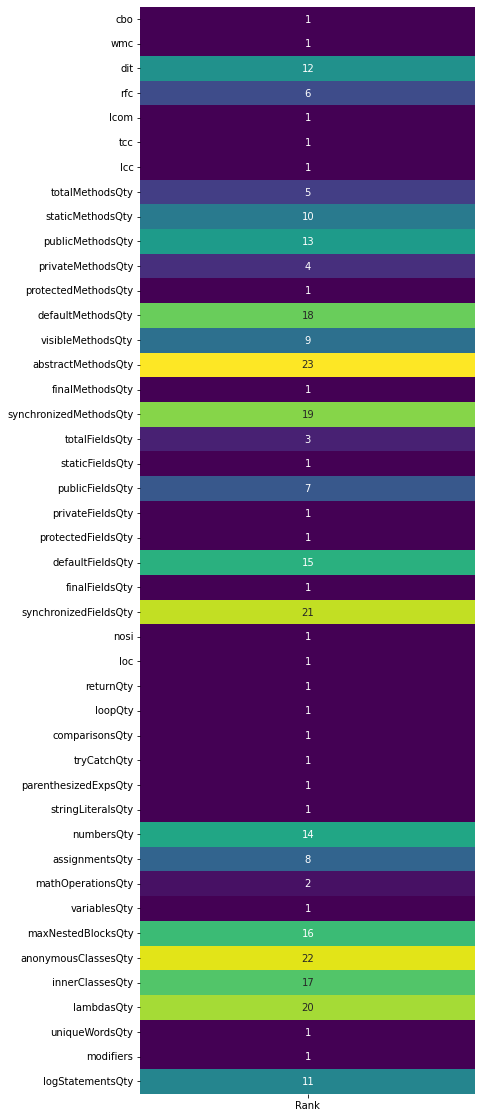

In [159]:
rfe_df = pd.DataFrame(rfe.ranking_,index=X_ros.columns,columns=['Rank'])
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,20))
sns.heatmap(rfe_df, annot=True, cmap='viridis', cbar=False)
plt.savefig('rfe_rankings.png', bbox_inches = 'tight')

In [140]:
def fit_feature_set(feature_set=final_features):
    X =train[feature_set]
    test_X = test[feature_set]
    y = train.vulnerable
    severity_y = train.severity
    title_y = train.title
    test_Y = test.vulnerable
    severity_test_Y = test.severity
    title_test_Y= test.title

In [ ]:
fit_feature_set(feature_set_1)

In [162]:
fit_feature_set(final_features)

In [26]:
len(final_features)

22

In [125]:
results_df = pd.DataFrame()
results_df['severity'] = dt_y_test_pred
results_df.to_csv("results_dt.csv", index= False)# This will write you submit_df with two columns in output folder.

NameError: name 'dt_y_test_pred' is not defined

In [63]:
#MLP Classifier
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam',
                    hidden_layer_sizes=(22,))

clf.fit(X_ros, y_ros)

MLPClassifier(hidden_layer_sizes=(22,))

In [64]:
print(f'Accuracy: {clf.score(X_ros, y_ros)}')

Accuracy: 0.8341022001419447


In [65]:
y_train_pred = clf.predict(X_ros)
mlp_test_pred = clf.predict(test_X)

In [179]:
sonarqube = ['java/org/apache/catalina/servlets/DefaultServlet.java','java/org/apache/catalina/tribes/group/interceptors/EncryptInterceptor.java',
            'java/org/apache/catalina/tribes/membership/cloud/AbstractStreamProvider.java',
             'java/org/apache/catalina/tribes/membership/cloud/CertificateStreamProvider.java',
             'java/org/apache/catalina/tribes/membership/cloud/InsecureStreamProvider.java',
             'java/org/apache/catalina/tribes/membership/cloud/TokenStreamProvider.java',
             'java/org/apache/tomcat/websocket/WsWebSocketContainer.java','test/org/apache/jasper/compiler/TestJspDocumentParser.java',
             'test/org/apache/tomcat/util/net/TesterSupport.java','webapps/examples/WEB-INF/web.xml']

In [179]:
sonarqube = ['java/org/apache/catalina/servlets/DefaultServlet.java','java/org/apache/catalina/tribes/group/interceptors/EncryptInterceptor.java',
            'java/org/apache/catalina/tribes/membership/cloud/AbstractStreamProvider.java',
             'java/org/apache/catalina/tribes/membership/cloud/CertificateStreamProvider.java',
             'java/org/apache/catalina/tribes/membership/cloud/InsecureStreamProvider.java',
             'java/org/apache/catalina/tribes/membership/cloud/TokenStreamProvider.java',
             'java/org/apache/tomcat/websocket/WsWebSocketContainer.java','test/org/apache/jasper/compiler/TestJspDocumentParser.java',
             'test/org/apache/tomcat/util/net/TesterSupport.java','webapps/examples/WEB-INF/web.xml']

In [180]:
sq = pd.DataFrame(sonarqube,columns=['sq_vulnerabilities'])

In [187]:
prediction = pd.DataFrame(list(zip(mlp_test_pred,test['class'].values[:],test.vulnerable.values[:])),columns=['model_predictions','class','actual_status'])

In [195]:
sorted(set(test.loc[test.vulnerable==1]['class'].values[:]))

['java/org/apache/catalina/mbeans/JmxRemoteLifecycleListener.java',
 'java/org/apache/catalina/realm/JNDIRealm.java',
 'java/org/apache/catalina/servlets/CGIServlet.java',
 'java/org/apache/catalina/servlets/DefaultServlet.java',
 'java/org/apache/catalina/session/FileStore.java',
 'java/org/apache/catalina/ssi/SSIPrintenv.java',
 'java/org/apache/catalina/startup/ContextConfig.java',
 'java/org/apache/catalina/startup/ExpandWar.java',
 'java/org/apache/catalina/startup/HostConfig.java',
 'java/org/apache/catalina/webresources/AbstractFileResourceSet.java',
 'java/org/apache/coyote/AbstractProtocol.java',
 'java/org/apache/coyote/Request.java',
 'java/org/apache/coyote/ajp/AbstractAjpProtocol.java',
 'java/org/apache/coyote/ajp/AjpProcessor.java',
 'java/org/apache/coyote/http11/AbstractHttp11Protocol.java',
 'java/org/apache/coyote/http11/Http11InputBuffer.java',
 'java/org/apache/coyote/http11/Http11Processor.java',
 'java/org/apache/coyote/http2/HpackDecoder.java',
 'java/org/apache

In [189]:
sq.merge(test,left_on='sq_vulnerabilities',right_on='class',how='left')

,sq_vulnerabilities,file,class,cbo,wmc,dit,rfc,lcom,tcc,lcc,totalMethodsQty,staticMethodsQty,publicMethodsQty,privateMethodsQty,protectedMethodsQty,defaultMethodsQty,visibleMethodsQty,abstractMethodsQty,finalMethodsQty,synchronizedMethodsQty,totalFieldsQty,staticFieldsQty,publicFieldsQty,privateFieldsQty,protectedFieldsQty,defaultFieldsQty,finalFieldsQty,synchronizedFieldsQty,nosi,loc,returnQty,loopQty,comparisonsQty,tryCatchQty,parenthesizedExpsQty,stringLiteralsQty,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,version,title,severity,vulnerable
0,java/javax/el/BeanELResolver.java,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,java/javax/el/ExpressionFactory.java,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,java/javax/security/auth/message/config/AuthCo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,java/javax/servlet/AsyncContext.java,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [224]:
titles = []
sev_labels = le.classes_
for i in mlp_test_pred:
    if i >= len(le.classes_):
        titles.append({'title':sev_labels[i-2]})
    else:
        titles.append({'title':sev_labels[i]})
pd.DataFrame(titles).to_json('mlp.csv')

In [203]:
mlp_test_pred

array([ 0,  1,  0,  0,  0,  0,  0,  0,  0, 10, 15,  0,  0,  0,  6,  6, 23,
        0,  0,  0,  0,  0,  0,  0,  7,  5,  0,  7,  0,  0,  0, 13,  7,  0,
        0,  0,  0, 13,  0,  0, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  4, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 23,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  1,  7,
        0,  0, 23, 20,  0,  0,  0,  0,  0, 20, 16,  0,  0, 13,  0,  0,  0,
        0,  6,  6,  0,  0,  0,  0,  0,  0,  0, 18,  7,  0,  0, 13,  0,  1,
        0,  0, 18, 17, 13,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0, 16,  7,
        1,  0,  0,  0,  0,  0,  1,  0,  0,  6,  0,  5,  7,  7,  0,  0,  0,
        0,  0, 20, 11,  0,  1,  0,  0,  0, 13,  3, 17,  0,  0,  0,  0,  0,
        0,  7,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0, 18,
        0,  0,  0, 13, 13,  0,  0,  0,  0,  7,  0,  0,  0,  1, 11, 10,  0,
        0,  0,  5,  0,  0

In [195]:
scores = cross_val_score(clf, X_ros, y_ros, scoring='accuracy', cv=kfold, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.782 (0.034)


In [77]:
# Decision Tree
model = DecisionTreeClassifier(random_state=0,ccp_alpha=0.06)
model.fit(X_ros, y_ros)
scores = cross_val_score(model, X_ros, y_ros, scoring='accuracy', cv=kfold, n_jobs=-1)
print('Precision: %.3f' % mean(cross_val_score(model, X_ros, y_ros, scoring='precision', cv=kfold, n_jobs=-1)))
print('Recall: %.3f' % mean(cross_val_score(model, X_ros, y_ros, scoring='recall', cv=kfold, n_jobs=-1)))
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
y_train_pred = model.predict(X_ros)
dt_y_test_pred = model.predict(test_X)

Precision: 0.774
Recall: 0.752
Accuracy: 0.767 (0.009)


In [176]:
prediction = pd.DataFrame(list(zip(y_test_pred,test['class'].values[:],test.vulnerable.values[:])),columns=['predictions','class','actual'])
prediction = prediction.drop_duplicates(keep='first').reset_index(drop=True)

In [177]:
prediction.loc[prediction.predictions==1]

,predictions,class,actual
0,1.0,java/org/apache/catalina/connector/Request.java,0.0
6,1.0,java/org/apache/catalina/core/ApplicationConte...,0.0
27,1.0,java/org/apache/catalina/core/ContainerBase.java,0.0
31,1.0,java/org/apache/catalina/core/NamingContextLis...,0.0
32,1.0,java/org/apache/catalina/core/StandardContext....,0.0
...,...,...,...
1175,1.0,java/org/apache/tomcat/websocket/WsFrameBase.java,1.0
1177,1.0,java/org/apache/tomcat/websocket/WsHandshakeRe...,0.0
1179,1.0,java/org/apache/tomcat/websocket/WsPongMessage...,0.0
1183,1.0,java/org/apache/tomcat/websocket/WsRemoteEndpo...,0.0


In [170]:
# KNN
model = KNN()
model.fit(X_ros, y_ros)
scores = cross_val_score(model, X_ros, y_ros, scoring='precision', cv=kfold, n_jobs=-1)
print('Precision: %.3f (%.3f)' % (mean(scores), std(scores)))
y_train_pred = model.predict(X_ros)
y_test_pred = model.predict(test_X)

Accuracy: 0.933 (0.008)


In [171]:
test.vulnerable.values[:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0.

In [172]:
prediction = pd.DataFrame(list(zip(y_test_pred,test['class'].values[:],test.vulnerable.values[:])),columns=['predictions','class','actual'])
prediction = prediction.drop_duplicates(keep='first').reset_index(drop=True)
prediction.loc[prediction.predictions==1].shape

(83, 3)

In [173]:
titles = []
sev_labels = le.classes_
for i in y_test_pred:
    if i >= len(le.classes_):
        titles.append({'title':sev_labels[i-2]})
    else:
        titles.append({'title':sev_labels[i]})
pd.DataFrame(titles).to_json('knn.csv')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [170]:
severities = []
sev_labels = ['0','High','Important','Moderate','Low']
for i in y_test_pred:
    severities.append(sev_labels[i])
severities

['High',
 '0',
 'Important',
 'Moderate',
 '0',
 '0',
 '0',
 '0',
 'High',
 'Low',
 'Important',
 '0',
 'Low',
 '0',
 'Moderate',
 '0',
 'Moderate',
 'High',
 '0',
 'Moderate',
 '0',
 '0',
 '0',
 'Moderate',
 'Moderate',
 'Low',
 '0',
 '0',
 '0',
 '0',
 'Low',
 'Low',
 'Important',
 'High',
 '0',
 'High',
 '0',
 'Low',
 'Important',
 '0',
 'Moderate',
 '0',
 '0',
 '0',
 'Low',
 'High',
 'Low',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 'Moderate',
 'Moderate',
 '0',
 '0',
 '0',
 '0',
 'Low',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 'Moderate',
 '0',
 '0',
 'Moderate',
 '0',
 '0',
 'Moderate',
 '0',
 '0',
 'Low',
 '0',
 'Important',
 'Moderate',
 'Moderate',
 '0',
 'Important',
 '0',
 '0',
 '0',
 'Moderate',
 '0',
 'Moderate',
 'Important',
 '0',
 'Important',
 '0',
 'Low',
 '0',
 'Important',
 'Moderate',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 'Important',
 'Low',
 'Moderate',
 'Low',
 '0',
 '0',
 '0',
 'High',
 '0',
 'Important',
 'Moderate',
 'High',
 '0',
 'Moderate',
 '0',
 'Important',


In [ ]:
results_df = pd.DataFrame()
results_df['title'] = y_test_pred
results_df.to_csv("results_knn.csv", index= False)# This will write you submit_df with two columns in output folder.

In [ ]:
# Logistic Regression
lr_model = LogisticRegression(solver='sag', class_weight='balanced')
lr_model.fit(X_ros, y_ros)
predictions2 = lr_model.predict(test_X)
scores = cross_val_score(lr_model, X_ros, y_ros, scoring='accuracy', cv=kfold, n_jobs=-1)
print('Precision: %.3f' % mean(cross_val_score(lr_model, X_ros, y_ros, scoring='precision', cv=kfold, n_jobs=-1)))
print('Recall: %.3f' % mean(cross_val_score(lr_model, X_ros, y_ros, scoring='recall', cv=kfold, n_jobs=-1)))
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


In [ ]:
titles = []
sev_labels = le.classes_
for i in predictions2:
    if i >= len(le.classes_):
        titles.append({'title':sev_labels[i-2]})
    else:
        titles.append({'title':sev_labels[i]})
pd.DataFrame(titles).to_json('lr.csv')

In [ ]:
results_df = pd.DataFrame()
results_df['severity'] = predictions2
results_df.to_csv("results_lr.csv", index= False)# This will write you submit_df with two columns in output folder.

In [173]:
# Naive Bayes Algorithm (Since the dataset is a bit too large too)
nb_model = GaussianNB()
nb_model.fit(X_ros,y_ros)
scores = cross_val_score(nb_model, X_ros, y_ros, scoring='accuracy', cv=kfold, n_jobs=-1)
print('Precision: %.3f' % mean(cross_val_score(nb_model, X_ros, y_ros, scoring='precision', cv=kfold, n_jobs=-1)))
print('Recall: %.3f' % mean(cross_val_score(nb_model, X_ros, y_ros, scoring='recall', cv=kfold, n_jobs=-1)))
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

predictions3 = nb_model.predict_proba(test_X)

Precision: nan
Recall: nan
Accuracy: 0.622 (0.004)


In [ ]:
results_df = pd.DataFrame()
results_df['severity'] = predictions3
results_df.to_csv("results_nb.csv", index= False)# This will write you submit_df with two columns in output folder.

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(severity_test_Y,dt_y_test_pred[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.title('Multiclass ROC curve DT')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);   
#fpr, tpr, thresh = roc_curve(severity_test_Y, dt_y_test_pred, pos_label=2)
#fpr1, tpr1, thresh1 = roc_curve(severity_test_Y, y_test_pred, pos_label=1)
#fpr2, tpr2, thresh2 = roc_curve(severity_test_Y, predictions2, pos_label=1)
#fpr3, tpr3, thresh3 = roc_curve(severity_test_Y, predictions3, pos_label=1)
# roc curve for tpr = fpr 
#random_probs = [0 for i in range(len(test_Y))]
#p_fpr, p_tpr, _ = roc_curve(severity_test_Y, random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score
# auc scores
auc_score1 = roc_auc_score(severity_test_Y, dt_y_test_pred, multi_class='ovr')
#auc_score1 = roc_auc_score(severity_test_Y, y_test_pred, multi_class='ovr')
#auc_score2 = roc_auc_score(severity_test_Y, predictions2, multi_class='ovr')
#auc_score3 = roc_auc_score(severity_test_Y, predictions3, multi_class='ovr')
#plt.style.use('seaborn')
print(auc_score1)

# plot roc curves
#plt.plot(fpr, tpr, linestyle='--', color='blue', label='Decision Tree')
#plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='KNN')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Logistic Regression')
#plt.plot(fpr3, tpr3, linestyle='--',color='yellow', label='Naive Bayes')
# title
#plt.title('ROC curve')
# x label
#plt.xlabel('False Positive Rate')
# y label
#plt.ylabel('True Positive rate')

#plt.legend(loc='best')
plt.show();